In [1]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

## Importing dataset

In [3]:
# Set the paths for train, test, and validation datasets
train_path =  r"C:\Users\Welcome\pneumonia_dataset\train"
test_path =  r"C:\Users\Welcome\pneumonia_dataset\test"
valid_path =  r"C:\Users\Welcome\pneumonia_dataset\val"

## Pre-processing the data

In [4]:
# Set the batch size and image dimensions
batch_size = 32
img_height = 256
img_width = 256

In [5]:
# Create Image Data Generators for train, test, and validation sets
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical',
    batch_size=batch_size
)

valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

# Determine the number of classes
num_classes = len(train.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Visualizing the pre-processed dataset

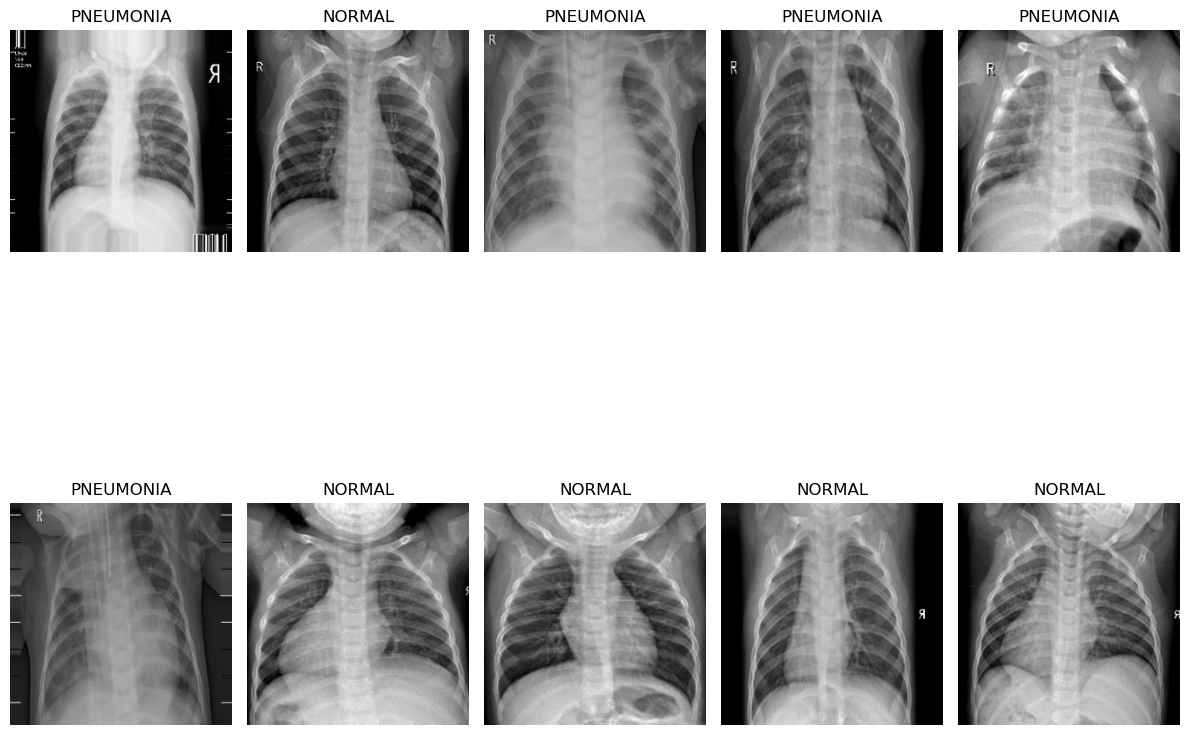

In [7]:
# Visualize a sample of the training images
plt.figure(figsize=(12, 12))
for i, (X_batch, Y_batch) in enumerate(train):
    for j in range(10):
        image = X_batch[j]
        label = Y_batch[j]
        dic = train.class_indices
        plt.subplot(2, 5, j+1)
        plt.title(list(dic.keys())[list(dic.values()).index(np.argmax(label))])
        plt.axis('off')
        plt.imshow(image)
    break
plt.tight_layout()
plt.show()

## Model Building

In [8]:
# Build the CNN model
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)))  # Allow images of any size
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='softmax', units=num_classes))

# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

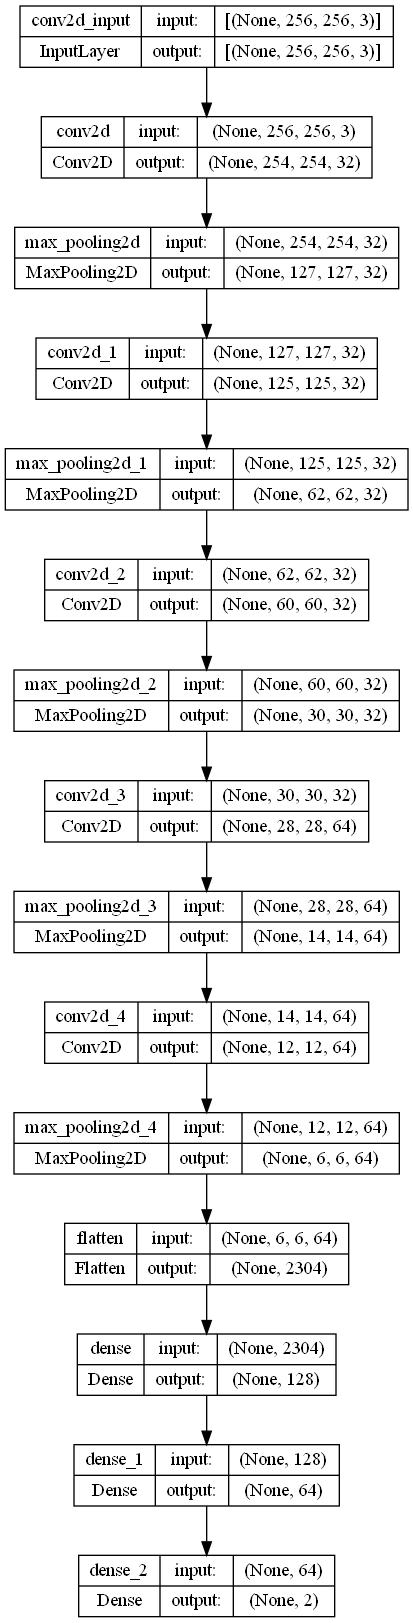

In [9]:
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [10]:
# Set up callbacks for early stopping and learning rate reduction
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [11]:
# Compute class weights
weights = compute_class_weight(
    'balanced',
    classes=np.unique(train.classes),
    y=train.classes
)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


## Fitting the model

In [12]:
# Train the model
cnn.fit(train, epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
163/163 [==============================] - 345s 2s/step - loss: 0.4638 - accuracy: 0.7418 - val_loss: 0.6189 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/25
163/163 [==============================] - 286s 2s/step - loss: 0.2343 - accuracy: 0.9057 - val_loss: 0.8614 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9151
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 297s 2s/step - loss: 0.2151 - accuracy: 0.9151 - val_loss: 1.1211 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/25
163/163 [==============================] - 290s 2s/step - loss: 0.1785 - accuracy: 0.9302 - val_loss: 0.9380 - val_accuracy: 0.6250 - lr: 3.0000e-04


<Axes: >

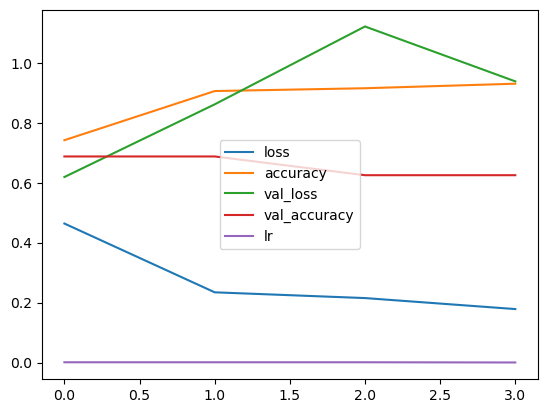

In [13]:
# Visualize the training and validation metrics
pd.DataFrame(cnn.history.history).plot()

In [14]:
# Evaluate the model on the test set
test_accu = cnn.evaluate(test, verbose=1)
print('The testing accuracy is:', test_accu[1] * 100, '%')

20/20 [==============================] - 26s 1s/step - loss: 0.3152 - accuracy: 0.8974
The testing accuracy is: 89.74359035491943 %


## Prediction

In [15]:
# Make predictions on the test set
preds = cnn.predict(test, verbose=1)

20/20 [==============================] - 15s 663ms/step


In [16]:
# Convert probabilities to binary predictions
predictions = np.argmax(preds, axis=1)

<Axes: >

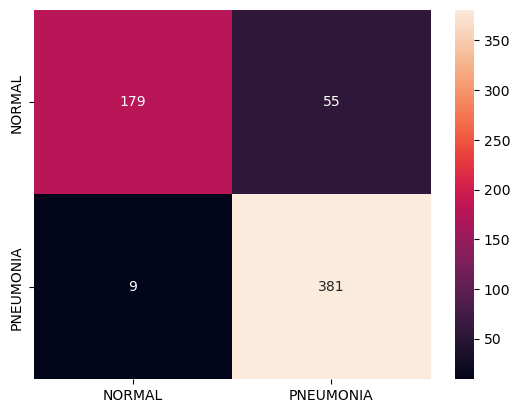

In [17]:
# Create a confusion matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions),
                  index=list(test.class_indices.keys()),
                  columns=list(test.class_indices.keys()))

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

In [18]:
# Print the classification report
print(classification_report(y_true=test.classes, y_pred=predictions, target_names=list(test.class_indices.keys())))

              precision    recall  f1-score   support

      NORMAL       0.95      0.76      0.85       234
   PNEUMONIA       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.87      0.89       624
weighted avg       0.90      0.90      0.89       624



In [19]:
# Extract images from the test data iterator
test.reset()
x = np.concatenate([test.next()[0] for i in range(test.__len__())])
y = np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 256, 256, 3)
(624, 2)


## Visualizing the predicted model 

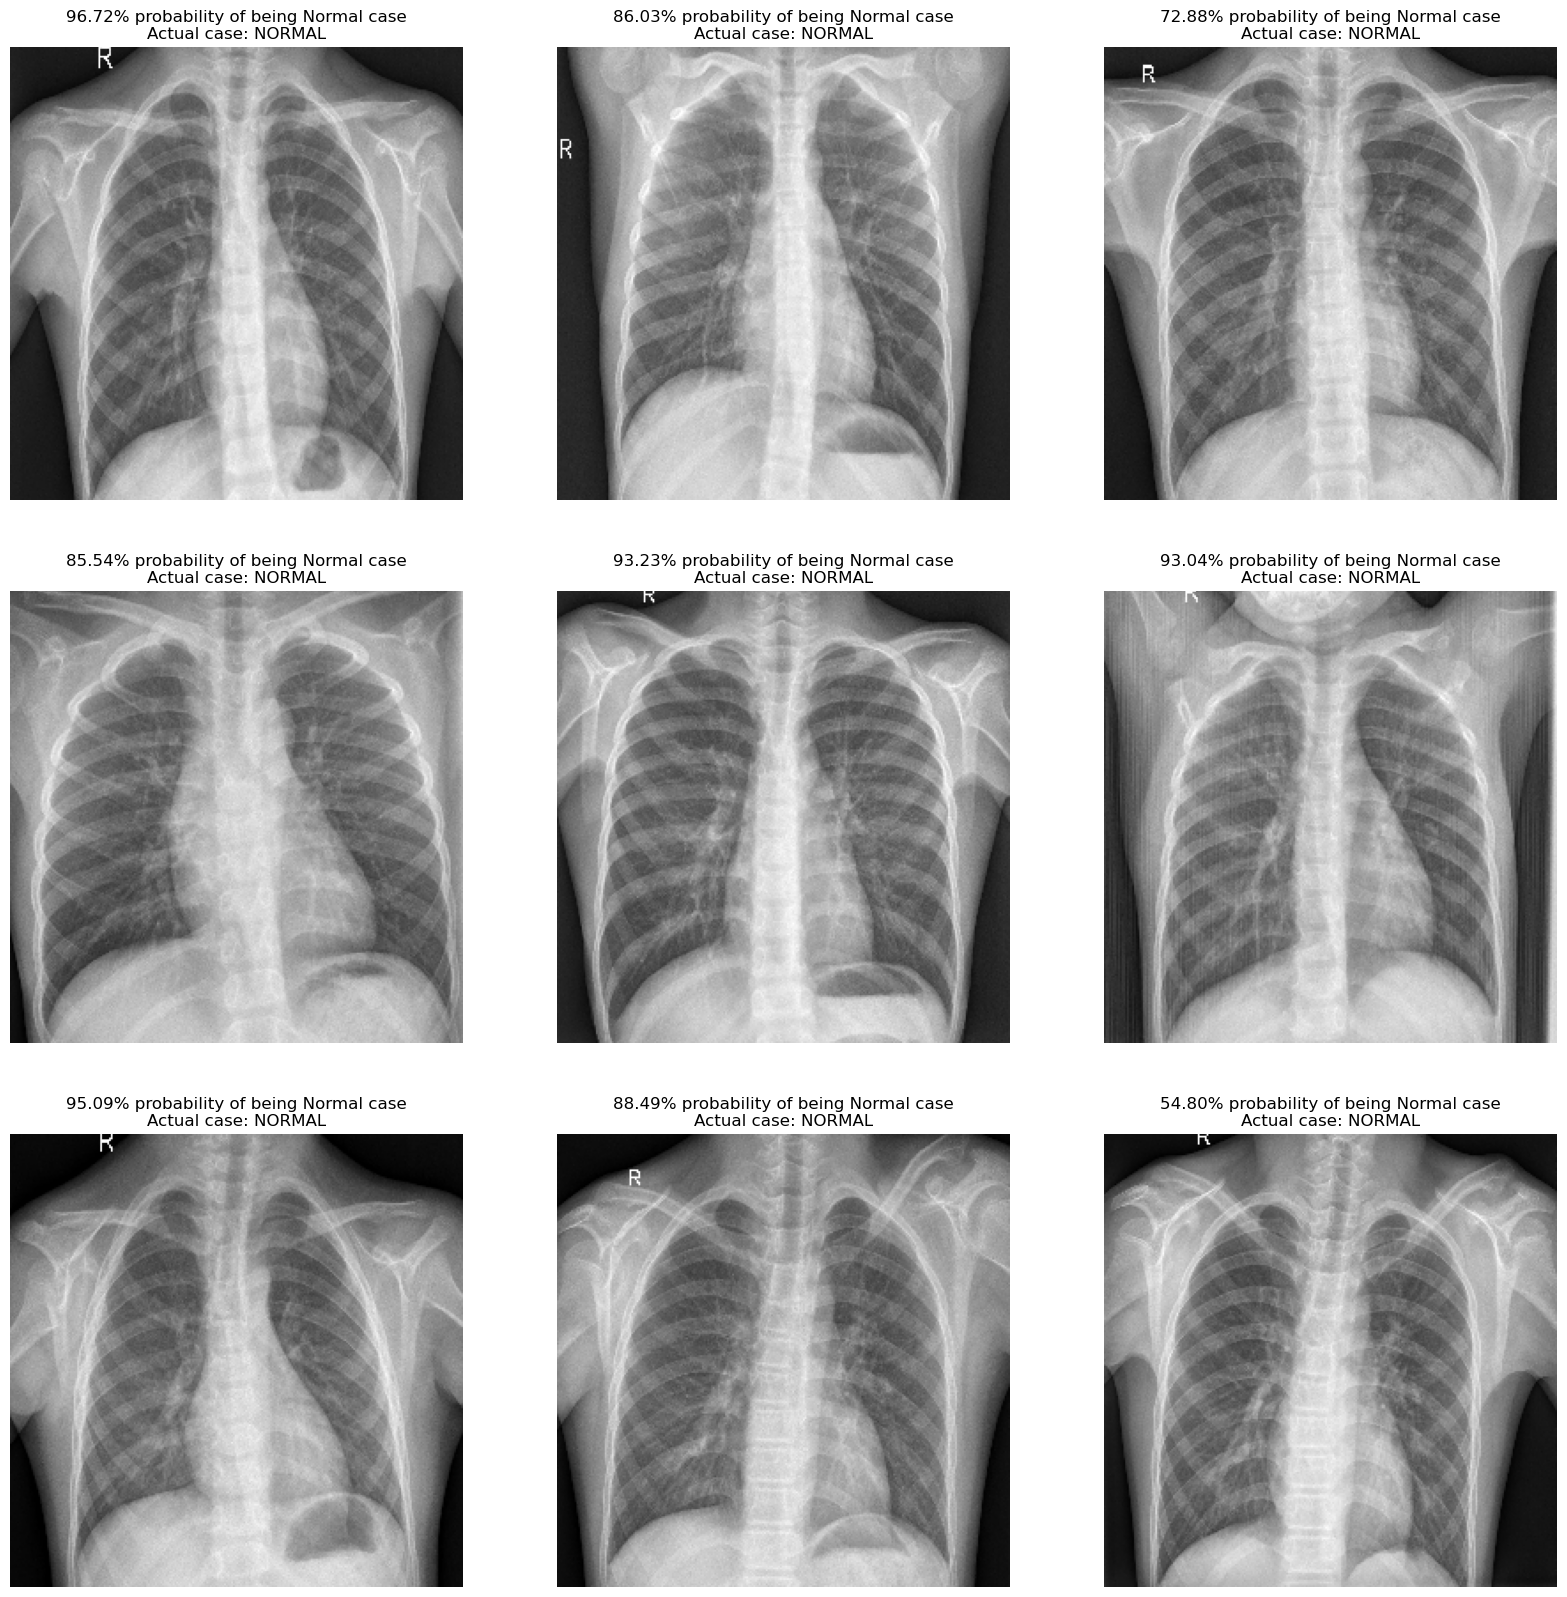

In [20]:
# Visualize a sample of the predicted images
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i+1)
    if preds[i, 1] >= 0.5:
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][1]))
    else:
        out = ('{:.2%} probability of being Normal case'.format(preds[i][0]))
    plt.title(out + "\nActual case: " + list(test.class_indices.keys())[list(test.class_indices.values()).index(predictions[i])])
    plt.imshow(x[i])
    plt.axis('off')
plt.show()

## Testing the predicted model

1/1 [==============================] - 0s 57ms/step


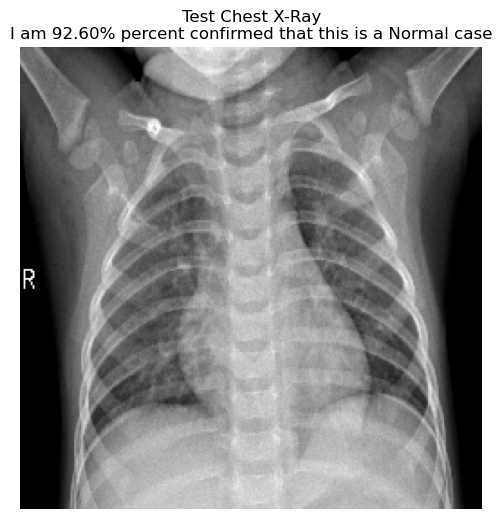

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Test with a custom chest X-ray image
test_img_path = r"C:\Users\Welcome\pneumonia_dataset\train\NORMAL\IM-0145-0001.jpeg"

# Load and preprocess the custom image
test_img = image.load_img(test_img_path, target_size=(img_height, img_width))
pp_test_img = image.img_to_array(test_img)
pp_test_img = pp_test_img / 255
pp_test_img = np.expand_dims(pp_test_img, axis=0)

# Resize the image to (256, 256)
pp_test_img = tf.image.resize(pp_test_img, (256, 256))

# Make predictions on the custom image
test_preds = cnn.predict(pp_test_img)
prediction = test_preds[0][0]

# Display the custom image and prediction
plt.figure(figsize=(6, 6))
plt.axis('off')
if prediction >= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(prediction))
else:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(1 - prediction))
plt.title("Test Chest X-Ray\n" + out)
plt.imshow(test_img)
plt.show()


### saving the model

In [22]:
# Save the model
cnn.save("pneumonia_trained_model.h5")